# Task 2: Knowledge Distillation in MHIST Dataset

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
import tensorflow.compat as tf1
import tensorflow_datasets as tfds


from typing import Union
!pip install keras-flops
from keras_flops import get_flops
from keras.layers import Conv2D, MaxPool2D, Dropout, Dense, Flatten,Input,GlobalAveragePooling2D

tf.enable_v2_behavior()

builder = tfds.builder('mnist')
BATCH_SIZE = 32
NUM_EPOCHS = 12
NUM_CLASSES = 2  # total classes.

     |████████████████████████████████| 462 kB 9.2 MB/s 


In [ ]:
import tensorflow.compat.v1 as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Convert the images to tensorflow dataset

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

dir = '/content/drive/My Drive/ECE1512_ProjectB/images/'
train_df = pd.read_csv(dir + 'train.csv')
test_df = pd.read_csv(dir + 'test.csv')

train_file_paths = train_df['Image Name'].values
train_labels = train_df['Majority Vote Label'].values

test_file_paths = test_df['Image Name'].values
test_labels = test_df['Majority Vote Label'].values

ds_train = tf.data.Dataset.from_tensor_slices((train_file_paths,train_labels))
ds_test = tf.data.Dataset.from_tensor_slices((test_file_paths,test_labels))

def preprocess(image_file,label):
  #image_file = tf1.as_str_any(image_file)
  image = tf.io.read_file(dir + image_file)
  image = tf.image.decode_image(image, channels=3, dtype=tf.float32)
  label = tf.one_hot(label, 2)
  return image, label

ds_train = ds_train.cache()
ds_train = ds_train.map(preprocess)
ds_train = ds_train.shuffle(len(train_df['Image Name'].values))
ds_train = ds_train.batch(BATCH_SIZE)

ds_test = ds_test.cache()
ds_test = ds_test.map(preprocess)
ds_test = ds_test.shuffle(len(test_df['Image Name'].values))
ds_test = ds_test.batch(BATCH_SIZE)

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Data augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomFlip('vertical'),
  tf.keras.layers.RandomRotation(0.2)
])

## Model Creation


In [ ]:
# Create the Student base model from the pre-trained model MobileNet V2
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)
student_base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

In [ ]:
student_base_model.trainable = True

In [ ]:
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in student_base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
teacher_base_model = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",

    input_shape=IMG_SHAPE)

teacher_base_model.trainable = True

#### Add a classification head

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = student_base_model(x, training=True)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
outputs = Dense(units = 2)(x)
student_without_KD_model = tf.keras.Model(inputs, outputs)

x = data_augmentation(inputs)
x = teacher_base_model(x, training=True)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
outputs = Dense(units = 2)(x)
teacher_model = tf.keras.Model(inputs, outputs)


In [ ]:
student_base_model_2 = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in student_base_model_2.layers[:fine_tune_at]:
  layer.trainable = False
  
x = data_augmentation(inputs)
x = student_base_model_2(x, training=True)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
outputs = Dense(units = 2)(x)
student_with_KD_model = tf.keras.Model(inputs, outputs)

## Build Train and evaluation Functions

### Use F1 score as the evaluation metric

In [ ]:
@tf.function
def f1_score(model, images, labels,precision,recall):
  """Update the tf Precision & Recall instance.

  Args:
    model: Instance of tf.keras.Model.
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.
    precision: Instance of tf.metrics.Precision
    recall: Instance of tf.metrics.Recall
  """
  class_logits = model(images, training=False)

  sparse_pred = tf.argmax(class_logits, -1)
  sparse_label = tf.argmax(labels, -1)

  precision.update_state(sparse_label,sparse_pred)
  recall.update_state(sparse_label,sparse_pred)
  return precision.result(), recall.result()

### Compute the number of correct sample function

In [ ]:
@tf.function
def compute_num_correct(model, images, labels):
  """Compute number of correctly classified images in a batch.

  Args:
    model: Instance of tf.keras.Model.
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Number of correctly classified images.
  """
  class_logits = model(images, training=False)
  return tf.reduce_sum(
      tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
              tf.float32)), tf.argmax(class_logits, -1), tf.argmax(labels, -1)


def train_and_evaluate(model, compute_loss_fn,verbose = True,lr=0.001,epochs = 10):

  optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

  for epoch in range(1, epochs + 1):
    # Run training.
    if verbose:
      print('Epoch {}: '.format(epoch), end='')
    for images, labels in ds_train:
      with tf.GradientTape() as tape:
                 # your code start from here for step 4

        loss_value =  compute_loss_fn(images, labels)

      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Run evaluation.
    precision = tf.metrics.Precision()
    recall  = tf.metrics.Recall()
    num_correct = 0
    num_total = len(test_df['Majority Vote Label'].values)
    for images, labels in ds_test:
      _, _ = f1_score(model,images,labels,precision,recall)
      num_correct += compute_num_correct(model, images, labels)[0]
    
    prec = precision.result().numpy()
    rec = precision.result().numpy()
    f1 = 2*prec*rec/(prec+rec)
    if verbose:
        print("F1 Score: " + '{:.2f}%'.format(
            f1*100))
        print("Class_accuracy: " + '{:.2f}%'.format(
            num_correct / num_total * 100))
  
  print("Final F1 Score: " + '{:.2f}%'.format(
            f1*100))
  print("Final Class_accuracy: " + '{:.2f}%'.format(
            num_correct / num_total * 100))
  return f1

### Compute plain cross entropy function

In [ ]:
def compute_plain_cross_entropy_loss(images, labels):

  student_subclass_logits = student_without_KD_model(images, training=True)
  cross_entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=student_subclass_logits))

  return cross_entropy_loss

### Compute teacher loss function

In [ ]:
def compute_teacher_loss(images, labels):

  subclass_logits = teacher_model(images, training=True)

  cross_entropy_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=subclass_logits))

  return cross_entropy_loss_value

### Compute distillation loss and student loss

In [ ]:
ALPHA = 0.5 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 8. #temperature hyperparameter

def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):

  soft_targets = tf.nn.softmax(teacher_logits/ temperature)

  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature)) * temperature ** 2

def compute_student_loss(images, labels):

  student_subclass_logits = student_with_KD_model(images, training=True)

  teacher_subclass_logits = teacher_model(images, training=False)

  distillation_loss_value = distillation_loss(teacher_subclass_logits, student_subclass_logits,
                      DISTILLATION_TEMPERATURE)

  cross_entropy_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=student_subclass_logits))

  return ALPHA*distillation_loss_value + (1-ALPHA)*cross_entropy_loss_value

In [ ]:
initial_epochs = 10
fine_tune_epochs = 25
total_epochs =  initial_epochs + fine_tune_epochs

## Train Teacher

In [ ]:
#Fine Tune
train_and_evaluate(teacher_model,compute_teacher_loss,lr=0.00001,epochs=total_epochs)


Epoch 1: F1 Score: 68.57%
Class_accuracy: 71.14%
Epoch 2: F1 Score: 72.48%
Class_accuracy: 73.18%
Epoch 3: F1 Score: 77.68%
Class_accuracy: 75.84%
Epoch 4: F1 Score: 75.11%
Class_accuracy: 75.13%
Epoch 5: F1 Score: 77.97%
Class_accuracy: 76.66%
Epoch 6: F1 Score: 81.78%
Class_accuracy: 79.22%
Epoch 7: F1 Score: 83.40%
Class_accuracy: 80.45%
Epoch 8: F1 Score: 82.07%
Class_accuracy: 79.63%
Epoch 9: F1 Score: 83.20%
Class_accuracy: 79.73%
Epoch 10: F1 Score: 84.38%
Class_accuracy: 81.17%
Epoch 11: F1 Score: 83.46%
Class_accuracy: 80.96%
Epoch 12: F1 Score: 84.50%
Class_accuracy: 81.37%
Epoch 13: F1 Score: 82.44%
Class_accuracy: 80.55%
Epoch 14: F1 Score: 84.51%
Class_accuracy: 83.21%
Epoch 15: F1 Score: 83.81%
Class_accuracy: 82.40%
Epoch 16: F1 Score: 83.93%
Class_accuracy: 82.60%
Epoch 17: F1 Score: 84.56%
Class_accuracy: 82.40%
Epoch 18: F1 Score: 88.74%
Class_accuracy: 81.47%
Epoch 19: F1 Score: 82.61%
Class_accuracy: 81.58%
Epoch 20: F1 Score: 83.09%
Class_accuracy: 81.99%
Epoch 21:

0.8561403751373291

In [ ]:
#teacher_model.save('/content/drive/My Drive/ECE1512_ProjectB/teacher_model')

INFO:tensorflow:Assets written to: /content/drive/My Drive/ECE1512_ProjectB/teacher_model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/ECE1512_ProjectB/teacher_model/assets


In [ ]:
#loaded_teacher_model = tf.keras.models.load_model('/content/drive/My Drive/ECE1512_ProjectB/teacher_model')

## Distill Teacher to  Student

In [ ]:
def compute_student_loss(images, labels):

  student_subclass_logits = student_with_KD_model(images, training=True)

  teacher_subclass_logits = loaded_teacher_model(images, training=False)

  distillation_loss_value = distillation_loss(teacher_subclass_logits, student_subclass_logits,
                      DISTILLATION_TEMPERATURE)

  cross_entropy_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=student_subclass_logits))

  return ALPHA*distillation_loss_value + (1-ALPHA)*cross_entropy_loss_value

def train_and_evaluate(model, compute_loss_fn,verbose = True,lr=0.001,epochs = 10):

  optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

  for epoch in range(1, epochs + 1):
    # Run training.
    if verbose:
      print('Epoch {}: '.format(epoch), end='')
    for images, labels in ds_train:
      with tf.GradientTape() as tape:
                 # your code start from here for step 4

        loss_value =  compute_loss_fn(images, labels)

      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Run evaluation.
    precision = tf.metrics.Precision()
    recall  = tf.metrics.Recall()
    num_correct = 0
    num_total = len(test_df['Majority Vote Label'].values)
    for images, labels in ds_test:
      _, _ = f1_score(model,images,labels,precision,recall)
      num_correct += compute_num_correct(model, images, labels)[0]
    
    prec = precision.result().numpy()
    rec = precision.result().numpy()
    f1 = 2*prec*rec/(prec+rec)
    if verbose:
        print("F1 Score: " + '{:.2f}%'.format(
            f1*100))
        print("Class_accuracy: " + '{:.2f}%'.format(
            num_correct / num_total * 100))
  
  print("Final F1 Score: " + '{:.2f}%'.format(
            f1*100))
  print("Final Class_accuracy: " + '{:.2f}%'.format(
            num_correct / num_total * 100))
  return f1, num_correct / num_total * 100


In [ ]:
#Fine Tune
Test_Accuracies = []
best_f1_score = 0
lr = 0.0001
for alp in np.linspace(0.5,0.9,3):
  Test_Accuracies_in_one_alp = []
  if round(alp, 1) == 0.5:
    temp_list = [1,2,4,16,32]
  else:
    temp_list = [1,32]
  for temp in temp_list:
    DISTILLATION_TEMPERATURE = temp
    ALPHA =alp
    print("Using Alpha {0}, Using Temperature {1}".format(alp, temp))

    student_base_model_2 = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

    x = data_augmentation(inputs)
    x = student_base_model_2(x, training=True)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)
    outputs = Dense(units = 2)(x)
    student_with_KD_model = tf.keras.Model(inputs, outputs)

    f1_scr, accuracy= train_and_evaluate(student_with_KD_model,compute_student_loss,lr=lr,epochs=total_epochs,verbose=False)

    Test_Accuracies_in_one_alp.append(accuracy)

    if f1_scr > best_f1_score:
      best_f1_score = f1_scr
      best_alp = alp
      best_temp = temp
      best_accuracy = accuracy
    print('\n')
  Test_Accuracies.append(Test_Accuracies_in_one_alp)
  print('\n')
print('The best F1 score after tunning is {0}, with ALPH = {1}, temperature = {2}, accuracy = {3}'
  .format(best_f1_score, best_alp, best_temp, best_accuracy))

Using Alpha 0.5, Using Temperature 1
Final F1 Score: 83.28%
Final Class_accuracy: 83.93%


Using Alpha 0.5, Using Temperature 2
Final F1 Score: 83.62%
Final Class_accuracy: 82.91%


Using Alpha 0.5, Using Temperature 4
Final F1 Score: 82.03%
Final Class_accuracy: 83.21%


Using Alpha 0.5, Using Temperature 16
Final F1 Score: 86.11%
Final Class_accuracy: 84.44%


Using Alpha 0.5, Using Temperature 32
Final F1 Score: 86.33%
Final Class_accuracy: 85.47%




Using Alpha 0.7, Using Temperature 1
Final F1 Score: 85.23%
Final Class_accuracy: 82.19%


Using Alpha 0.7, Using Temperature 32
Final F1 Score: 87.24%
Final Class_accuracy: 85.26%




Using Alpha 0.9, Using Temperature 1
Final F1 Score: 85.19%
Final Class_accuracy: 84.54%


Using Alpha 0.9, Using Temperature 32
Final F1 Score: 85.37%
Final Class_accuracy: 83.93%




The best F1 score after tunning is 0.8724138140678406, with ALPH = 0.7, temperature = 32, accuracy = 85.26100158691406


In [ ]:
#student_with_KD_model.save('/content/drive/My Drive/ECE1512_ProjectB/student_with_KD_model')

INFO:tensorflow:Assets written to: /content/drive/My Drive/ECE1512_ProjectB/student_with_KD_model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/ECE1512_ProjectB/student_with_KD_model/assets


## Test accuracy vs. tempreture curve

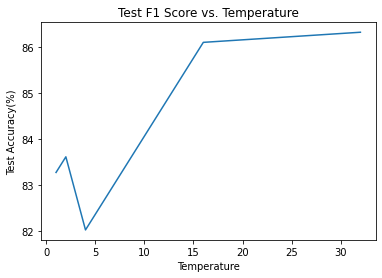

In [ ]:
#F1 scores Acquired from Above Results
F1=[83.28,83.62,82.03,86.11,86.33]
Temp = [1,2,4,16,32]

plt.plot(Temp,F1)
plt.xlabel('Temperature')
plt.ylabel('Test F1 Score(%)')
plt.title('Test F1 Score vs. Temperature')

plt.savefig('Temp vs Accuracy.svg',bbox_inches = 'tight')

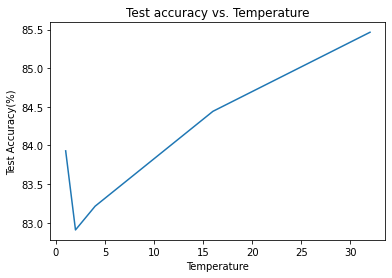

In [ ]:
# your code start from here for step 6
import matplotlib.pyplot as plt

plt.plot([1,2,4,16,32],Test_Accuracies[0])
plt.xlabel('Temperature')
plt.ylabel('Test Accuracy(%)')
plt.title('Test accuracy vs. Temperature')

plt.savefig('Temp vs Accuracy.svg',bbox_inches = 'tight')
plt.show()

## Train student from scratch

In [ ]:
#Fine Tune
train_and_evaluate(student_without_KD_model,compute_plain_cross_entropy_loss,lr=0.0001,epochs=total_epochs)

Epoch 1: F1 Score: 78.08%
Class_accuracy: 78.10%
Epoch 2: F1 Score: 77.02%
Class_accuracy: 76.87%
Epoch 3: F1 Score: 78.41%
Class_accuracy: 76.36%
Epoch 4: F1 Score: 81.47%
Class_accuracy: 79.84%
Epoch 5: F1 Score: 79.44%
Class_accuracy: 80.45%
Epoch 6: F1 Score: 77.89%
Class_accuracy: 79.94%
Epoch 7: F1 Score: 79.85%
Class_accuracy: 79.53%
Epoch 8: F1 Score: 85.65%
Class_accuracy: 78.40%
Epoch 9: F1 Score: 79.81%
Class_accuracy: 82.80%
Epoch 10: F1 Score: 85.02%
Class_accuracy: 80.86%
Epoch 11: F1 Score: 85.42%
Class_accuracy: 77.07%
Epoch 12: F1 Score: 81.18%
Class_accuracy: 80.45%
Epoch 13: F1 Score: 79.20%
Class_accuracy: 79.53%
Epoch 14: F1 Score: 80.75%
Class_accuracy: 79.84%
Epoch 15: F1 Score: 80.71%
Class_accuracy: 80.76%
Epoch 16: F1 Score: 81.85%
Class_accuracy: 80.04%
Epoch 17: F1 Score: 78.91%
Class_accuracy: 81.68%
Epoch 18: F1 Score: 82.11%
Class_accuracy: 81.88%
Epoch 19: F1 Score: 85.82%
Class_accuracy: 83.83%
Epoch 20: F1 Score: 85.83%
Class_accuracy: 81.27%
Epoch 21:

0.8211678862571716

## Comparing the teacher and student model (number of of parameters and FLOPs) 

### Teacher model

In [ ]:
# your code start from here for step 8
teacher_model.summary()
print('\nTeacher model FLOPs: ', get_flops(teacher_base_model, batch_size=1))

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 2)                 4098      
                                                           

Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`



Teacher model FLOPs:  6988273280


### Student model with KD

In [ ]:
student_with_KD_model.summary()
print('\nStudent model with KD FLOPs: ', get_flops(student_base_model_2, batch_size=1))

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 2)                 2562

Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`



Student model with KD FLOPs:  612663488


### Student model without KD

In [ ]:
student_without_KD_model.summary()
print('\nStudent model without KD FLOPs: ', get_flops(student_base_model, batch_size=1))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 2)                 2562  

##  Implementing the state-of-the-art KD algorithm

### Initialize Teacher-Assistant Model and Distill Teacher to TA

In [ ]:
# Create the TA base model from the pre-trained model Dense Net
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)
TA_base_model = tf.keras.applications.DenseNet169(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')


# Create the TA model
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = TA_base_model(x, training=True)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
outputs = Dense(units = 2)(x)
TA_model = tf.keras.Model(inputs, outputs)

### Compute TA loss and train function

In [ ]:
def compute_TA_loss(images, labels):

  student_subclass_logits = TA_model(images, training=True)

  teacher_subclass_logits = loaded_teacher_model(images, training=False)

  distillation_loss_value = distillation_loss(teacher_subclass_logits, student_subclass_logits,
                      DISTILLATION_TEMPERATURE)

  cross_entropy_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=student_subclass_logits))

  return ALPHA*distillation_loss_value + (1-ALPHA)*cross_entropy_loss_value

def train_and_evaluate(model, compute_loss_fn,verbose = True,lr=0.001,epochs = 10):

  optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

  for epoch in range(1, epochs + 1):
    # Run training.
    if verbose:
      print('Epoch {}: '.format(epoch), end='')
    for images, labels in ds_train:
      with tf.GradientTape() as tape:
                 # your code start from here for step 4

        loss_value =  compute_loss_fn(images, labels)

      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Run evaluation.
    precision = tf.metrics.Precision()
    recall  = tf.metrics.Recall()
    num_correct = 0
    num_total = len(test_df['Majority Vote Label'].values)
    for images, labels in ds_test:
      _, _ = f1_score(model,images,labels,precision,recall)
      num_correct += compute_num_correct(model, images, labels)[0]
    
    prec = precision.result().numpy()
    rec = precision.result().numpy()
    f1 = 2*prec*rec/(prec+rec)
    if verbose:
        print("F1 Score: " + '{:.2f}%'.format(
            f1*100))
        print("Class_accuracy: " + '{:.2f}%'.format(
            num_correct / num_total * 100))
  
  print("Final F1 Score: " + '{:.2f}%'.format(
            f1*100))
  print("Final Class_accuracy: " + '{:.2f}%'.format(
            num_correct / num_total * 100))
  return f1, num_correct / num_total * 100


In [ ]:
#Fine Tune the TA Model
Test_Accuracies = []
best_f1_score = 0
lr = 0.0001
for alp in np.linspace(0.5,0.9,3):
  Test_Accuracies_in_one_alp = []
  temp_list = [1,32]
  for temp in temp_list:
    DISTILLATION_TEMPERATURE = temp
    ALPHA =alp
    print("Using Alpha {0}, Using Temperature {1}".format(alp, temp))

    TA_base_model = tf.keras.applications.DenseNet169(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')


    # Create the TA model
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = data_augmentation(inputs)
    x = TA_base_model(x, training=True)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)
    outputs = Dense(units = 2)(x)
    TA_model = tf.keras.Model(inputs, outputs)

    f1_scr, accuracy= train_and_evaluate(TA_model,compute_TA_loss,lr=lr,epochs=total_epochs,verbose=False)

    Test_Accuracies_in_one_alp.append(accuracy)

    if f1_scr > best_f1_score:
      best_f1_score = f1_scr
      best_alp = alp
      best_temp = temp
      best_accuracy = accuracy
    print('\n')
  Test_Accuracies.append(Test_Accuracies_in_one_alp)
  print('\n')
print('The best F1 score after tunning is {0}, with ALPH = {1}, temperature = {2}, accuracy = {3}'
  .format(best_f1_score, best_alp, best_temp, best_accuracy))




Using Alpha 0.5, Using Temperature 1
Final F1 Score: 82.65%
Final Class_accuracy: 84.34%

Using Alpha 0.5, Using Temperature 32
Final F1 Score: 87.80%
Final Class_accuracy: 85.36%


Using Alpha 0.7, Using Temperature 1
Final F1 Score: 84.31%
Final Class_accuracy: 84.65%

Using Alpha 0.7, Using Temperature 32
Final F1 Score: 86.29%
Final Class_accuracy: 85.36%


Using Alpha 0.9, Using Temperature 1
Final F1 Score: 87.29%
Final Class_accuracy: 85.98%

Using Alpha 0.9, Using Temperature 32
Final F1 Score: 87.33%
Final Class_accuracy: 85.24%


The best F1 score after tunning is 0.878022453168406, with ALPH = 0.5, temperature = 32, accuracy = 85.36200255661211


In [ ]:
#TA_model.save('/content/drive/My Drive/ECE1512_ProjectB/TA_model')

INFO:tensorflow:Assets written to: /content/drive/My Drive/ECE1512_ProjectB/TA_model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/ECE1512_ProjectB/TA_model/assets


In [ ]:
print('\nTA model FLOPs: ', get_flops(TA_base_model, batch_size=1))

Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`



TA model FLOPs:  6757413696


### Distil TA Model to Student

In [ ]:
#TA_model = tf.keras.models.load_model('/content/drive/My Drive/ECE1512_ProjectB/TA_model')

In [ ]:
def compute_Student_TA_loss(images, labels):

  student_subclass_logits = Student_TA_model(images, training=True)

  teacher_subclass_logits = TA_model(images, training=False)

  distillation_loss_value = distillation_loss(teacher_subclass_logits, student_subclass_logits,
                      DISTILLATION_TEMPERATURE)

  cross_entropy_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=student_subclass_logits))

  return ALPHA*distillation_loss_value + (1-ALPHA)*cross_entropy_loss_value

In [ ]:
#Fine Tune
Test_Accuracies = []
best_f1_score = 0
lr = 0.0001
for alp in [0.6]:#np.linspace(0.5,0.9,3):
  Test_Accuracies_in_one_alp = []
  temp_list = [32]
  for temp in temp_list:
    DISTILLATION_TEMPERATURE = temp
    ALPHA =alp
    print("Using Alpha {0}, Using Temperature {1}".format(alp, temp))

    student_base_model_3 = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

    x = data_augmentation(inputs)
    x = student_base_model_3(x, training=True)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)
    outputs = Dense(units = 2)(x)
    Student_TA_model = tf.keras.Model(inputs, outputs)

    f1_scr, accuracy= train_and_evaluate(Student_TA_model,compute_Student_TA_loss,lr=lr,epochs=total_epochs,verbose=False)

    Test_Accuracies_in_one_alp.append(accuracy)


    if f1_scr > best_f1_score:
      best_f1_score = f1_scr
      best_alp = alp
      best_temp = temp
      best_accuracy = accuracy
    print('\n')
  Test_Accuracies.append(Test_Accuracies_in_one_alp)
  print('\n')
print('The best F1 score after tunning is {0}, with ALPH = {1}, temperature = {2}, accuracy = {3}'
  .format(best_f1_score, best_alp, best_temp, best_accuracy))

Using Alpha 0.5, Using Temperature 1
Final F1 Score: 83.35%
Final Class_accuracy: 84.08%

Using Alpha 0.5, Using Temperature 32
Final F1 Score: 87.33%
Final Class_accuracy: 86.02%


Using Alpha 0.7, Using Temperature 1
Final F1 Score: 83.31%
Final Class_accuracy: 82.65%

Using Alpha 0.7, Using Temperature 32
Final F1 Score: 86.39%
Final Class_accuracy: 85.97%


Using Alpha 0.9, Using Temperature 1
Final F1 Score: 85.89%
Final Class_accuracy: 85.23%

Using Alpha 0.9, Using Temperature 32
Final F1 Score: 86.33%
Final Class_accuracy: 84.12%


The best F1 score after tunning is 0.873333352458302, with ALPH = 0.5, temperature = 32, accuracy = 86.02216542896323
